# Quasar time-delay cosmology inference (from static datavectors)

This notebook mirrors `test_sne_forecast_time_delay.ipynb` and uses **only** redshifts + time delays
from `static_datavectors_seed6.json`. We infer Fermat potential differences from time delays using a
fiducial cosmology, then run cosmology inference with MST.

Assumptions:
- Inputs: `z_lens`, `z_src`, `td_measured` only.
- If a block has 3 time delays, we keep the **largest |time delay|** per lens.
- Time-delay errors: blocks 0–2 use 3% fractional; others use 5 days absolute.
- Fermat potential errors are block-dependent (set in `phi_err_frac_by_block`).
- MST is always included. Sigma_v errors map to lambda errors via sigma_v ∝ sqrt(lambda_int),
  so fractional lambda error = 2 * fractional sigma_v error.
- Blocks 7–8 have no sigma_v; their MST error uses the parent population sigma.
- Two modes: noisy observations vs. noiseless observations with likelihood noise.


In [1]:
import os
import sys
from pathlib import Path

workdir = Path.cwd()
if (workdir / "LensedUniverse").is_dir():
    workdir = workdir / "LensedUniverse"
os.chdir(workdir)
sys.path.insert(0, str(workdir))

import json
import numpy as np
import jax
import jax.numpy as jnp
import numpyro

from slcosmo.tools import tool

USE_X64 = os.environ.get("SLCOSMO_USE_X64", "0").strip().lower() in {"1", "true", "yes", "y", "on"}
jax.config.update("jax_enable_x64", USE_X64)
if USE_X64:
    numpyro.enable_x64()

if any(d.platform == "gpu" for d in jax.devices()):
    numpyro.set_platform("gpu")
else:
    numpyro.set_platform("cpu")
print("Precision mode:", "FP64" if USE_X64 else "FP32")

print("JAX devices:", jax.devices())
print("JAX default backend:", jax.default_backend())

SEED = 42
rng = np.random.default_rng(SEED)


Precision mode: FP32
JAX devices: [CudaDevice(id=0)]
JAX default backend: gpu


In [2]:
# ---------------------------
# Load redshifts + time delays from JSON
# ---------------------------
DATA_JSON = Path("../Temp_data/static_datavectors_seed6.json")
with DATA_JSON.open("r") as f:
    data = json.load(f)

z_lens_list = []
z_src_list = []
t_base_list = []
t_err_list = []
block_id_list = []
lens_id_list = []
pair_id_list = []

for b, block in enumerate(data):
    z_lens = np.asarray(block["z_lens"], dtype=float)
    z_src = np.asarray(block["z_src"], dtype=float)

    td = np.asarray(block["td_measured"], dtype=float)
    td_mean = td.mean(axis=1)  # (n_lens, n_td)

    n_lens, n_td = td_mean.shape

    if n_td == 3:
        idx = np.argmax(np.abs(td_mean), axis=1)
        t_base = np.abs(td_mean[np.arange(n_lens), idx])
        pair_id = idx
    else:
        t_base = np.abs(td_mean[:, 0])
        pair_id = np.zeros(n_lens, dtype=int)

    if b in (0, 1, 2):
        t_err = 0.03 * t_base
    else:
        t_err = np.full_like(t_base, 5.0)

    z_lens_list.append(z_lens)
    z_src_list.append(z_src)
    t_base_list.append(t_base)
    t_err_list.append(t_err)
    block_id_list.append(np.full(n_lens, b, dtype=int))
    lens_id_list.append(np.arange(n_lens, dtype=int))
    pair_id_list.append(pair_id)

z_lens = np.concatenate(z_lens_list)
z_src = np.concatenate(z_src_list)
t_base = np.concatenate(t_base_list)
t_err = np.concatenate(t_err_list)
block_id = np.concatenate(block_id_list)
lens_id = np.concatenate(lens_id_list)
pair_id = np.concatenate(pair_id_list)

print("Total lenses used (1 td per lens):", z_lens.size)


Total lenses used (1 td per lens): 800


In [3]:
# ---------------------------
# Fiducial cosmology and Fermat potential from time delays
# ---------------------------
cosmo_true = {"Omegam": 0.32, "Omegak": 0.0, "w0": -1.0, "wa": 0.0, "h0": 70.0}

zl_j = jnp.asarray(z_lens)
zs_j = jnp.asarray(z_src)
Dl, Ds, Dls = tool.dldsdls(zl_j, zs_j, cosmo_true, n=20)
Ddt_geom = (1.0 + zl_j) * Dl * Ds / Dls
Ddt_geom = np.asarray(Ddt_geom)

c_km_day = tool.c_km_s * 86400.0
Mpc_km = tool.Mpc / 1000.0

phi_true = (c_km_day * t_base) / (Ddt_geom * Mpc_km)


In [4]:
# ---------------------------
# MST + measurement model configuration
# ---------------------------
USE_NOISY_OBS = False

lambda_pop_mean = 1.0
lambda_pop_sigma = 0.05
lambda_low, lambda_high = 0.8, 1.2

phi_err_frac_by_block = {
    0: 0.02,
    1: 0.05,
    2: 0.05,
    3: 0.11,
    4: 0.11,
    5: 0.18,
    6: 0.18,
    7: 0.18,
    8: 0.18,
}

sigma_v_frac_by_block = {
    0: 0.03,
    1: 0.03,
    2: 0.03,
    3: 0.10,
    4: 0.10,
    5: 0.10,
    6: 0.10,
    7: np.nan,
    8: np.nan,
}

mst_mask = np.isfinite(np.asarray([sigma_v_frac_by_block[b] for b in block_id]))


phi_err_frac = np.asarray([phi_err_frac_by_block[b] for b in block_id])
phi_err = phi_err_frac * np.abs(phi_true)

lambda_true = tool.truncated_normal(
    lambda_pop_mean,
    lambda_pop_sigma,
    lambda_low,
    lambda_high,
    z_lens.size,
    random_state=rng,
)

sigma_v_frac = np.asarray([sigma_v_frac_by_block[b] for b in block_id])
mst_err_frac = 2.0 * sigma_v_frac

lambda_err = np.where(
    np.isfinite(mst_err_frac),
    mst_err_frac * np.abs(lambda_true),
    lambda_pop_sigma,
)

# MST always applied
t_true = t_base * lambda_true

# Observations: clean vs noisy

t_obs_clean = t_true.copy()
phi_obs_clean = phi_true.copy()
lambda_obs_clean = lambda_true.copy()

t_obs_noisy = t_true + rng.normal(0.0, t_err)
phi_obs_noisy = phi_true + rng.normal(0.0, phi_err)
lambda_obs_noisy = lambda_true + rng.normal(0.0, lambda_err)

# Scale Fermat potentials for stability

def scale_phi(phi_in):
    finite = np.isfinite(phi_in) & (phi_in != 0)
    if not np.any(finite):
        return phi_in, 1.0
    median = np.median(np.abs(phi_in[finite]))
    if (not np.isfinite(median)) or median == 0:
        return phi_in, 1.0
    exp = int(np.round(-np.log10(median)))
    scale = 10.0 ** exp
    return phi_in * scale, scale

phi_true_scaled, phi_scale = scale_phi(phi_true)
phi_obs_clean_scaled = phi_obs_clean * phi_scale
phi_obs_noisy_scaled = phi_obs_noisy * phi_scale
phi_err_scaled = phi_err_frac * np.abs(phi_true_scaled)

print("phi_scale:", phi_scale)
print("phi_obs scaled median:", np.median(np.abs(phi_true_scaled)))


phi_scale: 100000000000.0
phi_obs scaled median: 1.1395837007780671


In [5]:
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC
from jax import random

cosmo_prior = {
    "w0_up": 0.0,
    "w0_low": -2.0,
    "wa_up": 2.0,
    "wa_low": -2.0,
    "omegak_up": 1.0,
    "omegak_low": -1.0,
    "h0_up": 80.0,
    "h0_low": 60.0,
    "omegam_up": 0.5,
    "omegam_low": 0.1,
}


def cosmology_model(kind, cosmo_prior, sample_h0=True):
    cosmo = {
        "Omegam": numpyro.sample("Omegam", dist.Uniform(cosmo_prior["omegam_low"], cosmo_prior["omegam_up"])),
        "Omegak": 0.0,
        "w0": -1.0,
        "wa": 0.0,
        "h0": 70.0,
    }
    if kind in ["wcdm", "owcdm", "waw0cdm", "owaw0cdm"]:
        cosmo["w0"] = numpyro.sample("w0", dist.Uniform(cosmo_prior["w0_low"], cosmo_prior["w0_up"]))
    if kind in ["waw0cdm", "owaw0cdm"]:
        cosmo["wa"] = numpyro.sample("wa", dist.Uniform(cosmo_prior["wa_low"], cosmo_prior["wa_up"]))
    if kind in ["owcdm", "owaw0cdm"]:
        cosmo["Omegak"] = numpyro.sample("Omegak", dist.Uniform(cosmo_prior["omegak_low"], cosmo_prior["omegak_up"]))
    if sample_h0:
        cosmo["h0"] = numpyro.sample("h0", dist.Uniform(cosmo_prior["h0_low"], cosmo_prior["h0_up"]))
    return cosmo


def quasar_td_model(zl, zs, t_obs, t_err, phi_obs, phi_err, phi_scale, lambda_obs, lambda_err, mst_mask):
    cosmo = cosmology_model("waw0cdm", cosmo_prior, sample_h0=True)

    zl = jnp.asarray(zl)
    zs = jnp.asarray(zs)
    t_obs = jnp.asarray(t_obs)
    t_err = jnp.asarray(t_err)
    phi_obs = jnp.asarray(phi_obs)
    phi_err = jnp.asarray(phi_err)
    phi_scale = jnp.asarray(phi_scale)
    lambda_obs = jnp.asarray(lambda_obs)
    lambda_err = jnp.asarray(lambda_err)
    mst_mask = jnp.asarray(mst_mask)

    lambda_mean = numpyro.sample("lambda_mean", dist.Uniform(0.9, 1.1))
    lambda_sig = numpyro.sample("lambda_sig", dist.TruncatedNormal(0.05, 0.5, low=0.0, high=0.2))
    with numpyro.plate("lens", zl.shape[0]):
        lambda_true = numpyro.sample(
            "lambda_true",
            dist.TruncatedNormal(lambda_mean, lambda_sig, low=0.8, high=1.2),
        )
        numpyro.sample("lambda_like", dist.Normal(lambda_true, lambda_err).mask(mst_mask), obs=lambda_obs)

    Dl, Ds, Dls = tool.dldsdls(zl, zs, cosmo, n=20)
    Ddt_geom = (1.0 + zl) * Dl * Ds / Dls

    with numpyro.plate("td_obs", zl.shape[0]):
        phi_true_scaled = numpyro.sample("phi_true_scaled", dist.Normal(phi_obs, phi_err))
        phi_true = phi_true_scaled / phi_scale
        t_model_days = (Ddt_geom * Mpc_km / c_km_day) * phi_true
        t_model_days = t_model_days * lambda_true
        numpyro.sample("t_delay_like", dist.Normal(t_model_days, t_err), obs=t_obs)


In [6]:
# ---------------------------
# Run MCMC (optional)
# ---------------------------
RUN_MCMC = True

z_lens_s = z_lens
z_src_s = z_src

clean_data = {
    "t_obs": t_obs_clean,
    "t_err": t_err,
    "phi_obs": phi_obs_clean_scaled,
    "phi_err": phi_err_scaled,
    "phi_scale": phi_scale,
    "lambda_obs": lambda_obs_clean,
    "lambda_err": lambda_err,
}

noisy_data = {
    "t_obs": t_obs_noisy,
    "t_err": t_err,
    "phi_obs": phi_obs_noisy_scaled,
    "phi_err": phi_err_scaled,
    "phi_scale": phi_scale,
    "lambda_obs": lambda_obs_noisy,
    "lambda_err": lambda_err,
}

if RUN_MCMC:
    import arviz as az
    import matplotlib.pyplot as plt

    FIG_DIR = Path("result")
    FIG_DIR.mkdir(parents=True, exist_ok=True)

    def run_mcmc(data, key, tag):
        nuts = NUTS(quasar_td_model, target_accept_prob=0.95)
        mcmc = MCMC(nuts, num_warmup=500, num_samples=1000, num_chains=4, chain_method="vectorized")
        mcmc.run(
            key,
            zl=z_lens_s,
            zs=z_src_s,
            t_obs=data["t_obs"],
            t_err=data["t_err"],
            phi_obs=data["phi_obs"],
            phi_err=data["phi_err"],
            phi_scale=data["phi_scale"],
            lambda_obs=data["lambda_obs"],
            lambda_err=data["lambda_err"],
            mst_mask=mst_mask,
        )
        posterior = mcmc.get_samples(group_by_chain=True)
        inf_data = az.from_dict(posterior=posterior)

        extra = mcmc.get_extra_fields(group_by_chain=True)
        n_div = int(np.asarray(extra["diverging"]).sum())
        print(f"[{tag}] divergences: {n_div}")

        trace_vars = ["h0", "Omegam", "w0", "wa", "lambda_mean", "lambda_sig"]
        trace_vars = [v for v in trace_vars if v in inf_data.posterior and inf_data.posterior[v].ndim == 2]
        if trace_vars:
            trace_axes = az.plot_trace(inf_data, var_names=trace_vars, compact=False)
            trace_fig = np.asarray(trace_axes).ravel()[0].figure
            trace_fig.savefig(FIG_DIR / f"test_quasar_trace_{tag}.png", dpi=200, bbox_inches="tight")
            plt.close(trace_fig)
        return mcmc, inf_data, n_div

    key = random.PRNGKey(42)
    key_clean, key_noisy = random.split(key)

    mcmc_clean, inf_data_clean, n_div_clean = run_mcmc(clean_data, key_clean, "clean")
    mcmc_noisy, inf_data_noisy, n_div_noisy = run_mcmc(noisy_data, key_noisy, "noisy")

    var_names = ["h0", "Omegam", "w0", "wa", "lambda_mean", "lambda_sig"]
    print("Noiseless summary:")
    print(az.summary(inf_data_clean, var_names=var_names))
    print("Noisy summary:")
    print(az.summary(inf_data_noisy, var_names=var_names))


sample: 100%|██████████| 1500/1500 [02:24<00:00, 10.37it/s]


[clean] divergences: 24


sample: 100%|██████████| 1500/1500 [02:38<00:00,  9.48it/s]


[noisy] divergences: 37
Noiseless summary:
               mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
h0           72.223  2.172  68.161   76.220      0.075    0.035     829.0   
Omegam        0.363  0.102   0.168    0.500      0.002    0.001    1706.0   
w0           -1.141  0.393  -1.988   -0.519      0.013    0.007     965.0   
wa            0.192  1.018  -1.709    1.822      0.041    0.013     653.0   
lambda_mean   1.000  0.006   0.989    1.012      0.001    0.000      53.0   
lambda_sig    0.010  0.005   0.001    0.019      0.002    0.001       5.0   

             ess_tail  r_hat  
h0             1442.0   1.00  
Omegam         2256.0   1.00  
w0             1322.0   1.00  
wa             1936.0   1.01  
lambda_mean     126.0   1.05  
lambda_sig       12.0   2.12  
Noisy summary:
               mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
h0           72.644  2.348  68.259   76.997      0.060    0.038    1501.0   
Omegam        0.356  0.102   0.

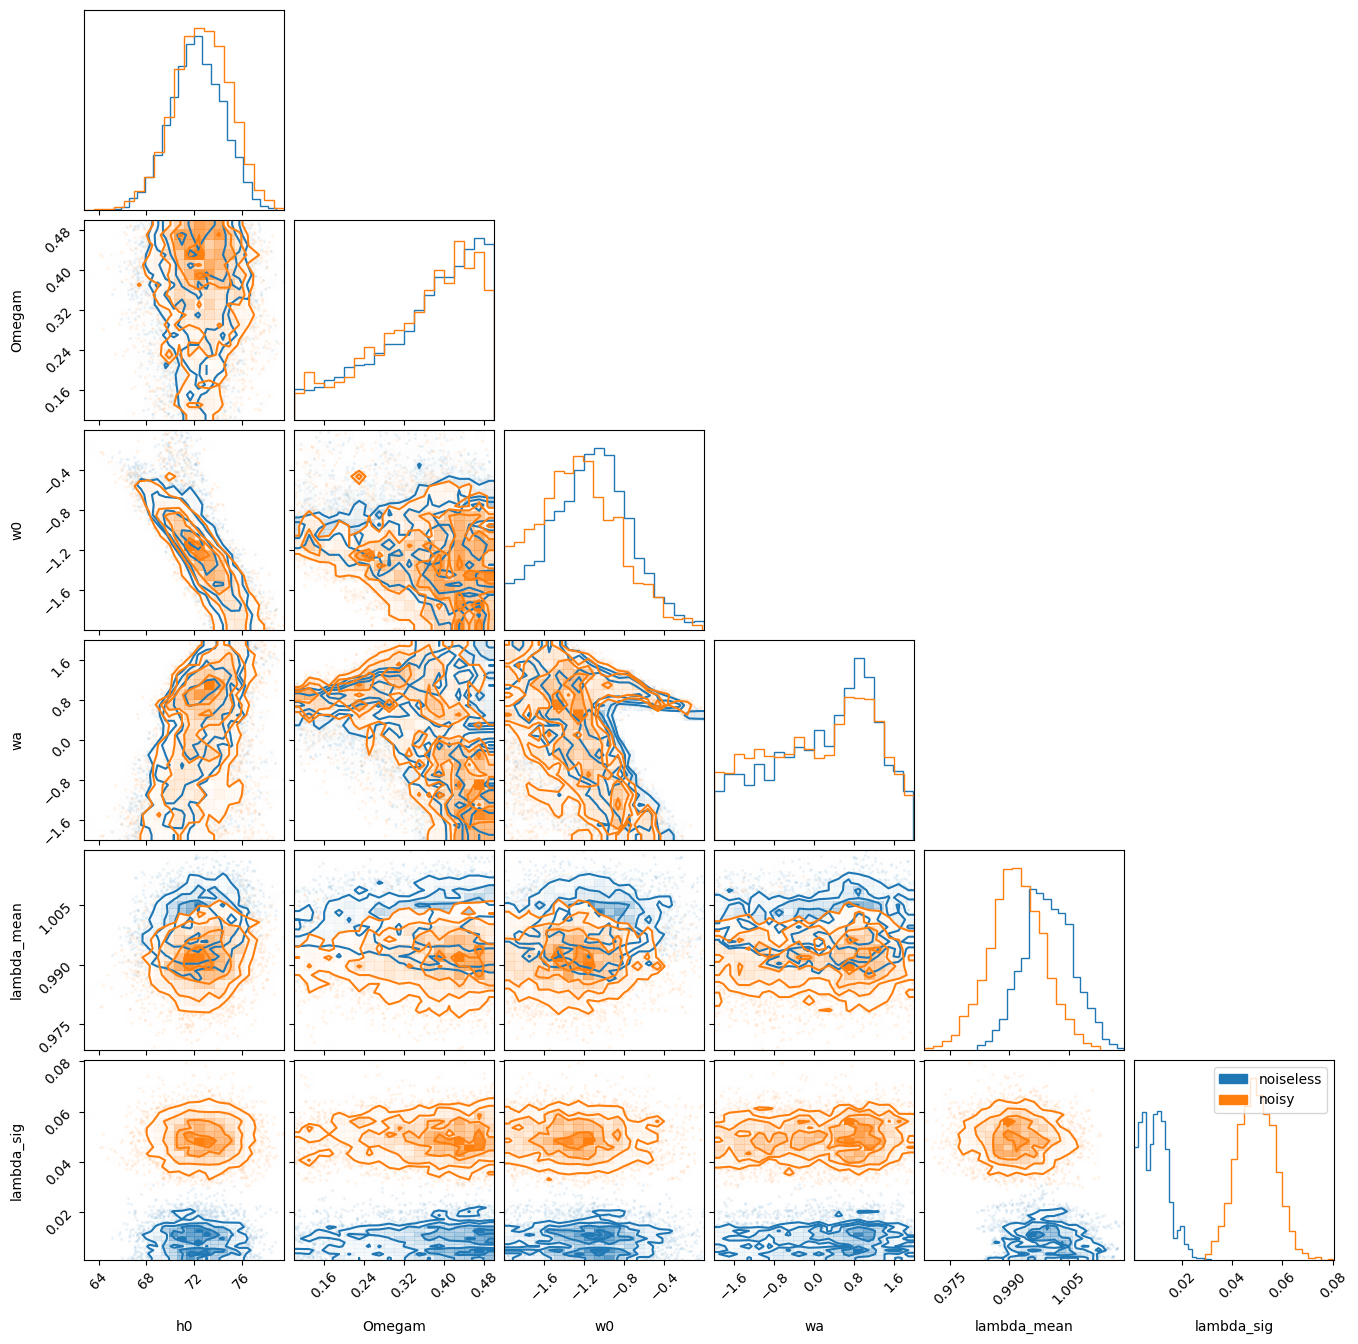

In [7]:
# ---------------------------
# Plotting (optional)
# ---------------------------
if RUN_MCMC:
    import arviz as az
    import matplotlib.pyplot as plt
    import corner
    import matplotlib.patches as mpatches

    FIG_DIR = Path("result")
    FIG_DIR.mkdir(parents=True, exist_ok=True)

    plot_clean = inf_data_clean.isel(chain=[0, 1, 2, 3])
    plot_noisy = inf_data_noisy.isel(chain=[0, 1, 2, 3])

    df_clean = az.extract(plot_clean, var_names=var_names).to_dataframe()
    df_noisy = az.extract(plot_noisy, var_names=var_names).to_dataframe()

    fig = corner.corner(df_clean, labels=var_names, color="C0")
    corner.corner(df_noisy, labels=var_names, color="C1", fig=fig)

    handles = [
        mpatches.Patch(color="C0", label="noiseless"),
        mpatches.Patch(color="C1", label="noisy"),
    ]
    plt.legend(handles=handles, loc="upper right")
    fig.savefig(FIG_DIR / "test_quasar_corner_overlay.png", dpi=200, bbox_inches="tight")
    plt.show()
